Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Unsupervised learning

In this coursework we're going to implement two classic unsupervised learning algorithms:

* K-means
* Principal components analysis

and we will apply them to two classic machine learning benchmark datasets,

* [Fisher's Iris flower data (1936)](https://en.wikipedia.org/wiki/Iris_flower_data_set)
* The [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/).





In [1]:
import numpy as np
import matplotlib.pyplot as plt

Load the iris dataset

In [2]:
def load_data():
    data = np.load('iris.npy')
    return data[:,:-1], data[:,-1]

X_iris, y_iris = load_data()
N, data_dim = X_iris.shape

## PART 1: Principal components analysis (4 points)

In the first part of the assignment, we're going to implement principal components analysis.

**Don't worry!** You can compute this however you want, but are encouraged to use numpy's linear algebra libraries, which will make this simple.

In particular, take a look at the methods in `numpy.linalg`:

* `np.linalg.svd` [[documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)] computes the singular value decomposition of a rectangular matrix. You will want to refer to the documentation to make sure that you:
    * correctly interpret the **three** return values
    * pass the correct options for the flags `full_matrices`, `compute_uv`, and `hermitian`
* `np.linalg.eig` [[documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)] computes eigenvalues and eigenvectors of a square matrix
* `np.linalg.eigh` [[documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)] also computes eigenvalues and eigenvectors, but only of **symmetric** square matrices (for which it is more efficient).

In the following function, we assume that the data a $N \times D$ matrix $\mathbf{X}$, and would like to compute the first $M$ prinicpal components.

The function should return:
* $\bar{\mathbf{x}} \in \mathbb{R}^D$, the mean of $\mathbf{X}$
* $\mathbf{W} \in \mathbb{R}^{D \times M}$, the projection matrix for transforming (and un-transforming) the data
* $\mathbf{s} \in \mathbb{R}^{D}$, the sequence of all $D$ singular values. We will use these to diagnose whether we chose an appropriate cutoff value of $M$, as well as to compute the explained variance.

In [3]:
def compute_PCA_parameters(X, M):
    """
    This function computes the first M prinicpal components of a
    dataset X. It returns the mean of the data, the projection matrix,
    and the associated singular values.
    
    While you can compute this however you want, `np.linalg.svd` is
    highly recommended. Please look at its documentation to choose
    its arguments appropriately, and on how to interpret its return values.
    
    [2 points]
    
    INPUT:
    X    : (N, D) matrix; each row is a D-dimensional data point
    M    : integer, <= D (number of principal components to return)
    
    OUTPUTS:
    x_bar  : (D,) vector, with the mean of the data
    W      : (D, M) semi-orthogonal matrix of projections
    s      : (D,) vector of singular values
    """

    # YOUR CODE HERE
    N,D = X.shape
    x_bar = np.mean(X, axis=0)
    u,s,V = np.linalg.svd(X-x_bar,full_matrices=False, compute_uv=True)
    #print(type(np.linalg.svd(X-x_bar,full_matrices=False, compute_uv=True)))
    #eigv = s**2/N
    #idx = (-eigv).argsort()[:M]
    W = V.T[:,:M]
    return x_bar, W, s


Compute the first two principal components.

In [4]:
N_components = 2
x_bar, W, s = compute_PCA_parameters(X_iris, N_components)

Now we'll run a few self-tests to make sure that the implementation is correct. To start, we will
* double-check that all the returned matrices have the correct dimensions, and
* double-check that the matrix $\mathbf{W}$ is actually orthogonal, i.e. with $\mathbf{W}^\top \mathbf{W} = \mathbf{I}$.

In [5]:
assert x_bar.shape == (data_dim,)
assert W.shape == (data_dim, N_components)
assert s.shape == (data_dim,)


In [6]:
assert np.allclose(W.T @ W, np.eye(N_components))


### Now, implement methods to transform (and un-transform) your data.

You can find the equations for this in the slides (or in either of the textbook chapters).

In [7]:
def PCA_transform(X, W, x_bar):
    """ 
    Apply the PCA transformation to data (reducing dimensionality).
    
    [1 point]
    
    INPUTS:
    X     : (N, D) matrix; each row is a D-dimensional data point
    W     : (D, M) semi-orthogonal matrix of projections
    x_bar : (D,) vector, with the mean of the data

    OUTPUT:
    Z     : (N, M) matrix of transformed data
    """
    # YOUR CODE HERE
    diff = X - x_bar
    Z = diff@W
    return Z

def PCA_inverse_transform(Z, W, X_bar):
    """
    Apply the PCA inverse transformation, to reconstruct the data
    from the low-dimensional projection.
    
    [1 point]
    
    INPUTS:
    Z     : (N, M) matrix of transformed data
    W     : (D, M) semi-orthogonal matrix of projections
    x_bar : (D,) vector, with the mean of the data

    OUTPUT:
    X     : (N, D) matrix; each row is a D-dimensional data point
    """
    
    # YOUR CODE HERE
    diff = Z@W.T
    X = diff + X_bar
    return X

The singular values that you computed while finding the projection matrix correspond exactly to the explained and unexplained variance.

In the following plot, we show the singular values divided by the number of data points, to show the amount of variance captured in each dimension on a per-datapoint scale.

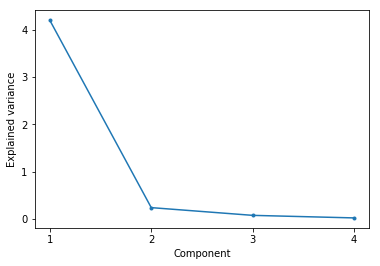

In [8]:
plt.plot(np.arange(data_dim)+1, s**2 / N, '.-')
plt.xticks(np.arange(data_dim)+1)
plt.xlabel('Component');
plt.ylabel('Explained variance');
plt.show()

This provides another way of double-checking that your implementation is correct!

The following cell computes two quantities:

$$\frac{1}{N} \sum_{i=1}^N \| \mathbf{x}_i - \hat{\mathbf{x}}_i \|_2^2$$

$$\frac{1}{N} \sum_{j =M+1}^D s_j^2$$

If all the implementations are correct, these values should be the same — the sum of variance from the remaining dimensions should exactly be the sum of the squared reconstruction error.

In [9]:
Z_iris = PCA_transform(X_iris, W, x_bar)
X_hat = PCA_inverse_transform(Z_iris, W, x_bar)

squared_error_tr = ((X_iris - X_hat)**2).sum(-1).mean()
unexplained_variance = (s[N_components:]**2).sum() / N


print("Average squared reconstruction error: %0.5f" % squared_error_tr)
print("Sum of remaining singular values: %0.5f" % unexplained_variance)

Average squared reconstruction error: 0.10136
Sum of remaining singular values: 0.10136


In [10]:
assert np.isclose(squared_error_tr, unexplained_variance)


In [11]:
# (GRADING)


### Plotting using PCA

Assuming the code is working, we can now use this to make a 2d plot of this 4d dataset.

Visually, you can compare this to the PCA plot in the Matrix Factorization lecture slides (you can also compare against the "pairs" plot there that shows each pair of dimensions against each other in turn!). Remember that the sign of each embedding dimension is arbitrary.

There's no coding assignment here — just run and look at the plots and make sure everything seems okay before moving on to the next section.

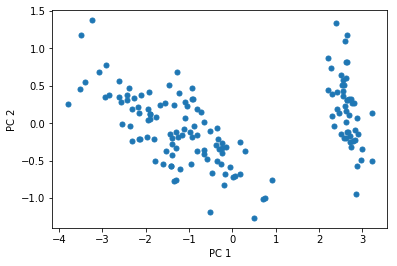

In [12]:
plt.figure(figsize=(6,4))
plt.plot(Z_iris[:,0], Z_iris[:,1], '.', markersize=10)
plt.xlabel("PC 1");
plt.ylabel("PC 2");
plt.show()

### This dataset actually does have labels.

The measurements correspond to three different species of flowers.

We can plot this data colored by the species:

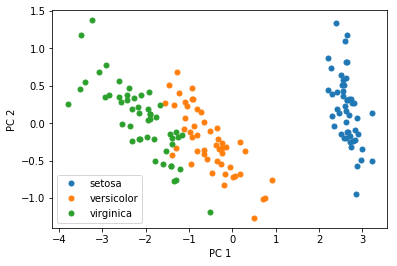

In [13]:
plt.figure(figsize=(6,4))
for k in range(3):
    plt.plot(Z_iris[y_iris==k,0], Z_iris[y_iris==k,1], '.', color='C%d'%k, markersize=10)
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.xlabel("PC 1");
plt.ylabel("PC 2");
plt.show()

Interestingly, a very large amount of the variance is actually captured just by the very first principal component. We can also visualize a 1d projection:

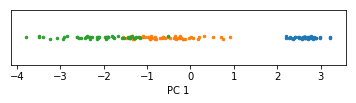

In [14]:
plt.figure(figsize=(6,1))
for k in range(3):
    plt.plot(Z_iris[y_iris==k,0], np.random.rand(sum(y_iris==k))*0.1-0.05, '.', color='C%d'%k, markersize=5)
plt.yticks([])
plt.ylim(-1, 1);
plt.xlabel("PC 1");
plt.show()

## PART 2: K-Means (5 points)

Next, we will implement the K-means algorithm. We'll first run this on the Iris dataset, for testing, and then try it out on a more challenging problem.

You will have to implement three functions:

* `update_cluster_means` takes the data and a current cluster assignment, and computes new updated cluster centers.
    * **You will need to decide yourself** how to handle clusters that have no points assigned to them. (Any behavior that allows the overall algorithm to run successfully is acceptable!)
* `update_cluster_assignments` takes the data and a set of cluster means, and computes new updated cluster assignments.
    * You aren't being graded explicitly on efficiency, but do try to make it run reasonably fast. It is possible to vectorize this operation using only numpy functions.
    * You can re-use your own code from previous assignments if that is helpful (though it might not be!).
* `fit_k_means` takes a data matrix and runs the "outer loop" of the K-means algorithm. **You will need to decide for yourself:**
    * How to initialize the algorithm
    * What is an appropriate stopping criteria

The supplied `within_cluster_ss` function evaluates how well the data fits the current set of cluster means and assignments.

In [15]:
def within_cluster_ss(X, z, mu, K):
    """ Returns the total within-cluster sum of squared distances from centers """
    ss = 0
    for k in range(K):
        ss += ((X[z==k] - mu[k])**2).sum()
    return ss

In [16]:
def update_cluster_means(X, z, K):
    """ 
    Update the cluster means, given the data and a current cluster assignment
    
    [2 points]
    
    INPUTS:
    X     : (N, D) data matrix; each row is a D-dimensional data point
    z     : (N,) vector of integers indicating current cluster assignment
    K     : integer; target number of clusters

    OUTPUT:
    mu    : (K, D) matrix of cluster centers (means)
    """
    N, D = X.shape
    
    # YOUR CODE HERE
    mu = np.zeros((K,D))
    for k in range(K):
        idx = np.where(z==k)[0]
        if len(idx) != 0:
            mu[k] = np.mean(X[idx], axis=0)
        else:
            mu[k] = X[np.random.randint(N)]
    return mu

In [17]:
def update_cluster_assignments(X, mu):
    """ 
    Update cluster assignments, given the data and current cluster means
    
    [2 points]
    
    INPUTS:
    X     : (N, D) data matrix; each row is a D-dimensional data point
    mu    : (K, D) matrix of cluster centers (means)

    OUTPUT:
    z     : (N,) vector of integers indicating current cluster assignment
    """

    # YOUR CODE HERE
    N,D = X.shape
    K,D = mu.shape
    z = np.zeros(N)
    for i,x in enumerate(X):
        dist = np.linalg.norm(x-mu,axis=1)
        z[i] = np.argmin(dist)
    z = z.astype(int)
    return z

You can evaluate both these functions by running tests on simple examples where the "correct" behaviour is obvious.

In [18]:
assert np.allclose(update_cluster_means(np.array([[1.0], [2.0], [3.0]]), 
                                        np.array([0, 0, 1]), 2),
                   np.array([[1.5], [3.0]]))



In [19]:
assert np.allclose(update_cluster_assignments(np.array([[1.0, 1.0], 
                                                        [0.0, 2.0],
                                                        [3.0, 0.0]]), 
                                              np.array([[0.5, 0.5],
                                                        [4.0, -1.0]])),
                   np.array([0,0,1]))



In [20]:
# (GRADING)


In [21]:
# (GRADING)


In [22]:
def fit_k_means(X, K):
    """
    Using both `update_cluster_means` and `update_cluster_assignments` to
    implement the K-means algorithm.
    
    You will need to decide for yourself:
        * how to initialize the algorithm;
        * what is an appropriate stopping criteria.
    
    [1 point]
    
    INPUTS:
    X    : (N, D) data matrix; each row is a D-dimensional data point
    K    : integer, target (maximum) number of clusters

    OUTPUTS:
    z     : (N,) vector of integers indicating final cluster assignment
    mu    : (K, D) matrix of final computed cluster centers (means)
    iters : integer, number of iterations required (measured in terms of
            calls to `update_cluster_assignments`). This is just for 
            diagnosis --- you will not be graded on the value of this
            number being "correct".
    """
    
    # YOUR CODE HERE
    N,D = X.shape
    prev_z = np.random.randint(0,K,N)
    z = np.random.randint(0,K,N)
    mu = update_cluster_means(X, z, K)
    iters = 0   
    while np.array_equal(prev_z,z) == False:
        prev_z = z
        z = update_cluster_assignments(X, mu)
        mu = update_cluster_means(X, z, K)
        iters += 1
    return z, mu, iters

### The following cell runs the K-means algorithm for a range of K, from 1 to 10.

It then plots the within-cluster sum-of-squares, i.e., the total sum of squared distances from each point to its associated cluster center, for each different value of $K$. 

This is effectively the "cluster loss" associated with K-means.

* *Question*: before running this cell, what do you think this plot will look like? After running it, do you think your implementation is correct?
* *Question*: how can you use this plot to determine the appropriate choice of $K$?
* *Question*: if you re-run this many times, do the results change?

K = 1: 0 iterations
K = 2: 4 iterations
K = 3: 12 iterations
K = 4: 11 iterations
K = 5: 6 iterations
K = 6: 6 iterations
K = 7: 16 iterations
K = 8: 8 iterations
K = 9: 10 iterations


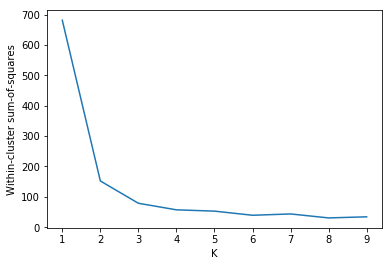

In [23]:
WSS = []
res = []
Ks = range(1, 10)
for K in Ks:
    z, mu, iters = fit_k_means(X_iris, K)
    print("K = %d: %d iterations" % (K, iters))
    WSS.append(within_cluster_ss(X_iris, z, mu, K))
    res.append((z, mu))
    
plt.plot(Ks, WSS);
plt.xlabel("K")
plt.ylabel("Within-cluster sum-of-squares");
plt.show()

### The following code makes a scatter plot of the clusters you just learned, visualized using the PCA representation you found above!

This should help you visually diagnose whether your code is doing the right thing.

It also can help you decide whether you were right about your choice of "appropriate" K.

In [24]:
def plot_K_means_pca(X, z, mu, W=None, x_bar=None):
    """ Plot K-means results. Will attempt to use your PCA implementation! 
    
        If your PCA implementation doesn't work, don't worry -- it will fall back
        to just using the first two dimensions of the data instead.
    """
    use_pca = True
    try:
        pca_X = PCA_transform(X, W, x_bar)
        pca_mu = PCA_transform(mu, W, x_bar)
    except:
        pca_X = X
        pca_mu = mu
        use_pca = False
    cluster_ids = np.unique(z)
    for k in cluster_ids:
        plt.plot(pca_X[z==k,0], pca_X[z==k,1], '.', color='C%d'%k, label='cluster %d' % k, markersize=10)
    for k in np.arange(z.max()+1):
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='red', markersize=20, label=None)
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='green', markersize=18, label=None)
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='C%d'%k, markersize=12, label='mean %d' % k)
    if use_pca:
        plt.xlabel("PCA Axis 1")
        plt.ylabel("PCA Axis 2");
    else:
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2");
    plt.legend();
    plt.show()

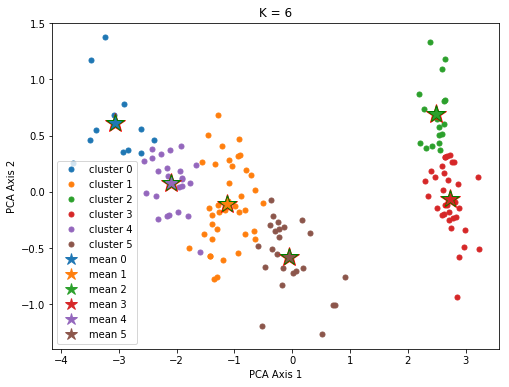

In [26]:

# CHANGE THIS TO PLOT DIFFERENT VALUES!
K = 6


plt.figure(figsize=(8,6))
plt.title("K = %d" % K)
z, mu = res[K-1]
plot_K_means_pca(X_iris, z, mu, W, x_bar)

In [27]:
# (GRADING)


## PART 3: K-means on the MNIST data (1 point)

The Iris data doesn't really lend itself to clustering. Instead, for something more interesting, we're going to cluster the MNIST dataset, which consists of 60,000 hand-written digits. Each digit is a 28 by 28 greyscale image.

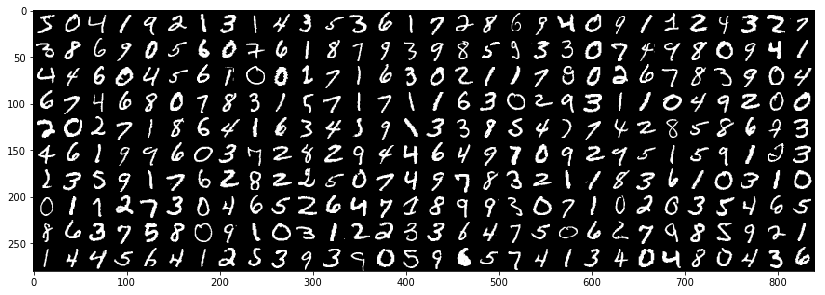

In [28]:
MNIST = np.load("mnist.npz")
mnist_images = MNIST['X']

def make_img_grid(images, n_cols=10):
    """ Helper function for arranging images into a grid """
    cols = []
    gap = len(images) % n_cols
    if gap > 0:
        # add padding if needed
        images = np.concatenate((images, np.zeros((n_cols-gap,)+images[0].shape)), 0)
    for n in range(n_cols):
        cols.append(np.concatenate(images[np.arange(n, len(images), step=n_cols)]))
    return np.concatenate(cols, -1)

plt.figure(figsize=(14,7))
plt.imshow(make_img_grid(mnist_images[:300], n_cols=30), cmap='binary_r');
plt.show()

### PCA as pre-processing for K-means

One challenge with K-means is that it can be slow to find the nearest cluster centers for each datapoint. This is particularly for high dimensional data (or for large K).

A very very easy way to speed things up is to pre-process the data by reducing its dimensionality.

Here, we will run PCA as pre-processing. The next cells reshape the original MNIST data, from

* `mnist_images.shape == [60000, 28, 28]`

into a 2d array (matrix)

* `X_mnist.shape == [60000, 784]`.

In that form, you should be able to run PCA on it. My implementation of PCA, running on a laptop, **takes less than 5 seconds to run**. (If this step is very slow, you may want to double-check your PCA implementation!)

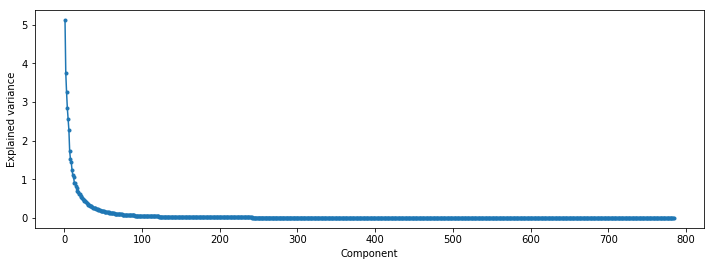

Wall time: 23.1 s


In [29]:
%%time

X_mnist = mnist_images.reshape(-1, 784) # reshape to 2d matrix

mnist_mean, W_mnist, s_mnist = compute_PCA_parameters(X_mnist, 50)

N, data_dim = X_mnist.shape
plt.figure(figsize=(12,4))
plt.plot(np.arange(data_dim)+1, s_mnist**2 / N, '.-')
plt.xlabel('Component');
plt.ylabel('Explained variance');
plt.show()

**Use the plot above to decide how many components you will need to expect to have reasonable results.**

### Your task:

Complete the following function, `k_means_pca_mnist`.

This function should do the following steps:

1. Take the data and project it down to a small (specified) number of components
2. Run K-means on the low-dimensional representation
3. Return the cluster labels

Note that if you select a very large number of components, your code may be *very slow* unless you did a *very good job* implementing your K-means algorithm efficiently.

On the other hand, if you choose a very small number of components, you may return clusters that are fairly meaningless.

**You will receive full credit for this section so long as:**
* your code returns a "reasonable" clustering (This should be obvious once inspecting your clusters visually!)
* it finishes running within the cutoff time (Aim to keep it under one minute to be safe!)

My reference implementation ran in about ~30 seconds on my laptop.

In [30]:
def k_means_pca_mnist(X_mnist, K):
    """
    Run K-means on PCA-transformed MNIST data.

    There is a "number of components" variable which you should hard-code
    at the top of this function!
    
    [1 point]

    INPUTS:
    X_mnist : (60000,784) matrix of MNIST data
    K       : integer, target number of clusters
    
    OUTPUTS:
    z       : (60000,) vector of integers containing cluster assignments
    iters   : integer, number of iterations (for reference only)
    """

    # SET THIS VALUE TO SOMETHING SMALLER THAN 784!
    N_components = 70 #784
    
    # YOUR CODE HERE
    mnist_mean, W_mnist, s_mnist = compute_PCA_parameters(X_mnist, N_components)
    transformed_X = PCA_transform(X_mnist, W_mnist, mnist_mean)
    z, _, iters = fit_k_means(transformed_X, K)
    return z, iters
    


Now, we will run this clustering code, looking for $K = 20$ clusters.

*N.B.: my implementation took less than 30 seconds to run.*

In [31]:
%%time

z_mnist, iters = k_means_pca_mnist(X_mnist, K=20)

Wall time: 3min 22s


### Visualizing clusters

The best way to visualize these clusters is to just go ahead and plot a large number of examples from each! Hopefully, you'll see that they do in fact resemble clusters.

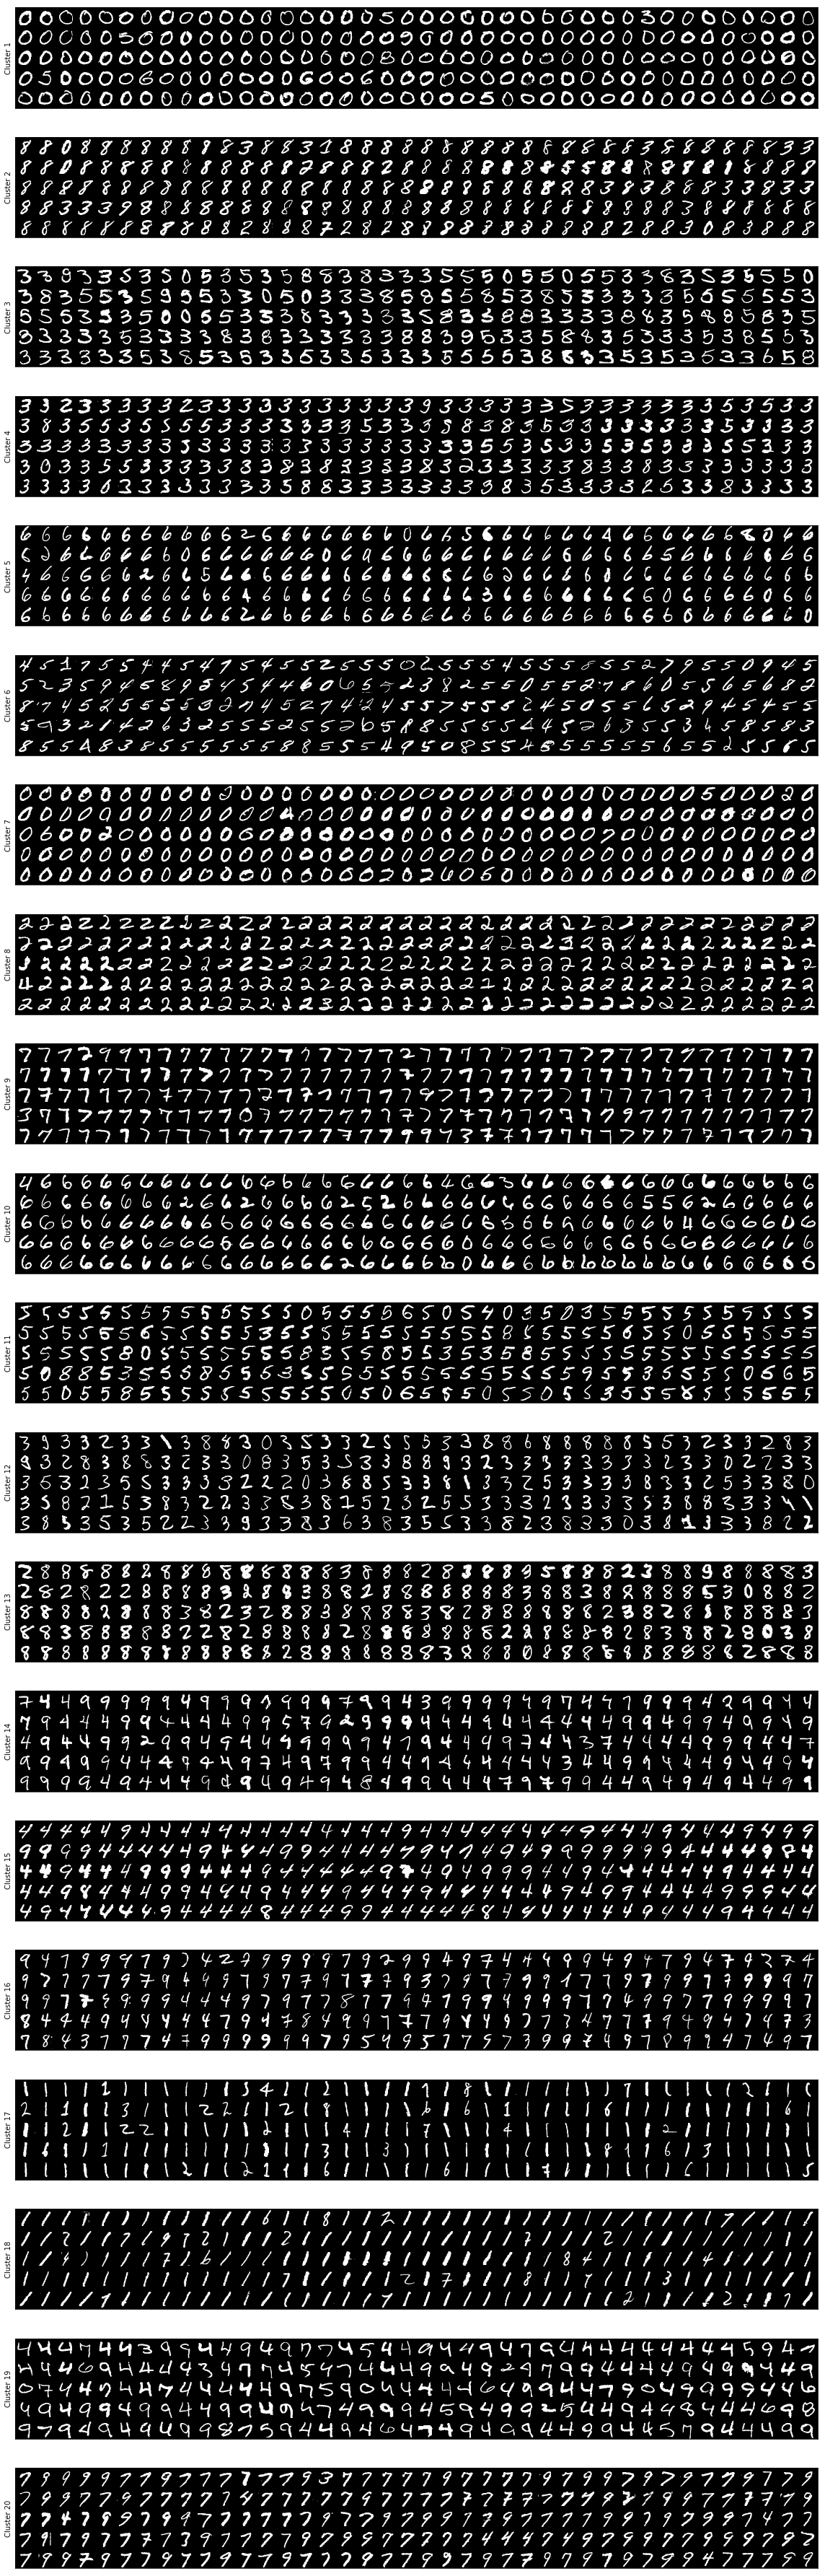

In [32]:
plt.figure(figsize=(16, 50))
for k in range(20):
    plt.subplot(20, 1, k+1)
    plt.imshow(make_img_grid(mnist_images[z_mnist==k][:200], n_cols=40), cmap='binary_r');
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Cluster %d" % (k+1))
plt.tight_layout();
plt.show()

Of course, you can also compute and plot the means themselves, though this might not be as informative (they will likely be "blurry" averages, rather than actual realistic images).

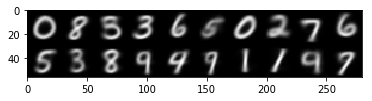

In [33]:
mu_mnist = update_cluster_means(X_mnist, z_mnist, 20)
plt.imshow(make_img_grid(mu_mnist.reshape(20,28,28)), cmap='binary_r');
plt.show()

In [34]:
# (GRADING)


